# Global Churn Prediction

In this notebook we want to use the full set of data we have for each contract (the product, agent and customer data for this customer are aggregated), in order to predict whether it is a potential churner.

The underlying idea is that if we are able to be accurate, then we can analyse the model, and draw conclusions in order to undertake appropriate actions to limit churn.

This means this rampstudio challenge is particularly interesting only under the constraint of using interpretable models, such as linear regressions or trees.

Let us follow the usual steps for ramp-studio challenges, and then conclude with an example of interpretation.

## Summary:
1. [Convert data into a training and testing set](#1-bullet)  <br>
2. [Extract Features](#2-bullet)  <br>
3. [Classify](#3-bullet)  <br>
4. [Test locally](#4-bullet)  <br>
5. [Test locally with Ramp framework](#5-bullet)  <br>
6. [Interpretation](#6-bullet)  <br>
    6.1 [Visualizing the features relative importance](#6.1-bullet)  <br>
    6.2 [Visualizing the decision making process](#6.2-bullet)   <br>
    6.3 [Conclusion](#6.3-bullet)   <br>

## 1. Convert data into a training and testing set <a class="anchor" id="1-bullet"></a> 

In [1]:
data_folder = "data/"
visualization_folder = "graphviz/"
training_data = data_folder + "train.csv"
data_builder_path = "DataBuilder.py"
feature_extractor_path = "submissions/starting_kit/feature_extractor.py"
classifier_path = "submissions/starting_kit/classifier.py"

In [3]:
# %load "DataBuilder.py"
import pandas as pd
from sklearn.model_selection import train_test_split


data_path = "../"
############### Customer One-Hot encoded data
df_customers = pd.read_csv(data_path + "customer_info.csv", sep=",", parse_dates=True)
df_customers = df_customers.drop(columns=["time_stamp", "customer_social_group"])
df_customers = pd.get_dummies(df_customers, columns=["customer_origin", "customer_gender", "customer_marital_cd"], drop_first=True)
df_customers = df_customers.drop(columns=["customer_gender_F", "customer_marital_cd_3"])
df_customers[:15]

############### Agents One-Hot encoded data
df_agents = pd.read_csv(data_path + "agent_info.csv", sep=",", parse_dates=True)
df_agents = df_agents.drop(columns="time_stamp")
df_agents = pd.get_dummies(df_agents, columns=["agent_status"], drop_first=True)
df_agents[:15]

############### Policies One-Hot encoded data
df_policy_data = pd.read_csv(data_path + "policy_info.csv", sep=",", parse_dates=True)
df_policy_data = df_policy_data.drop(columns=["policy_status", "last_payment_dt","payment_method", "policy_issue_dt", "time_stamp"])
df_policy_data = pd.get_dummies(df_policy_data, columns=["contact_channel", "policy_status_cd", "product_code"], drop_first=True)
df_policy_data = df_policy_data.drop(columns=["policy_status_cd_B", "product_code_BP_00479053"])
df_policy_data[:15]

############### Joining on customer_id and agent_id
df_policy_allInfo = pd.merge(df_policy_data, df_agents, on='agent_id')
df_policy_allInfo = pd.merge(df_policy_allInfo, df_customers, on='customer_id')
df_policy_allInfo = df_policy_allInfo.drop(columns=["customer_id", "agent_id"]) # we remove the information which is specific to each individual
df_policy_allInfo[:15]

############### Gathering latest policy info
df_policy_latest_info = pd.read_csv(data_path + "latest_policy_info.csv", sep=",", parse_dates=True)
df_policy_latest_info["time_stamp"] = pd.to_datetime(df_policy_latest_info["time_stamp"], format='%Y-%m-%d')
df_policy_latest_info["last_termination_dt"] = pd.to_datetime(df_policy_latest_info["last_termination_dt"], format='%Y-%m-%d')

############### Making target predictions
df_policy_cancelled = df_policy_latest_info.dropna(subset=["policy_id", "last_policy_status"]) #drop Na only for this columns
df_policy_cancelled["status"]= df_policy_latest_info["last_policy_status"].map(lambda x: 1 if x=="active" else 0.) # cancelled = 0.
df_policy_cancelled = df_policy_cancelled.drop(columns=["last_policy_status", "last_termination_dt", "time_stamp"])
df_policy_cancelled[:10]

X = pd.merge(df_policy_allInfo, df_policy_cancelled, on='policy_id')
X = X.dropna() # Apparently there were some hidden NaN values
X = X.drop(columns=["policy_id"])
X_train, X_test = train_test_split(X, test_size=.25, shuffle=True, random_state=42)
X_train.to_csv("data/train.csv", index=False)
X_test.to_csv("data/test.csv", index=False)

## 2. Extract Features <a class="anchor" id="2-bullet"></a> 

In [4]:
# %load "submissions/starting_kit/feature_extractor.py"
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

class FeatureExtractor(object):
    def __init__(self):
        self.scaler = StandardScaler()

    def fit(self, X_df, y):
        self.scaler.fit(X_df)

    def transform(self, X_df):
        X_scaled = self.scaler.transform(X_df)
        return X_scaled

## 3. Classify <a class="anchor" id="3-bullet"></a> 

In [5]:
# %load "submissions/starting_kit/classifier.py"
from sklearn.base import BaseEstimator
from sklearn.ensemble import RandomForestClassifier

class Classifier(BaseEstimator):
    
    def __init__(self, n_estimators=40, max_depth=20):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.clf = RandomForestClassifier(n_estimators=self.n_estimators, class_weight="balanced", max_depth=self.max_depth)
        
    def fit(self, X, y):
        self.clf.fit(X, y)
        
    def predict(self, X):
        return self.clf.predict(X)

    def predict_proba(self, X):
        return self.clf.predict_proba(X)

## 4. Test locally <a class="anchor" id="4-bullet"></a> 

In [6]:
#local test: import data
import pandas as pd

X_train = pd.read_csv(training_data)
y_train = X_train["status"].copy()
X_train = X_train.drop(columns=["status"])
X_train.head(15)

,sum_assured,policy_premium,nb_riders,rider_premium,contact_channel_broker,contact_channel_direct,contact_channel_partnership,product_code_BP_00170090,product_code_BP_00334803,product_code_BP_01087308,...,agent_active_portfolio,agent_inactive_portfolio,agent_status_inactive,customer_age,customer_income,customer_additional_products,customer_origin_new,customer_gender_M,customer_marital_cd_1,customer_marital_cd_2
0,1720000.0,2800.0,2.0,2100.0,0,0,0,0,1,0,...,259.0,97.0,0,40.0,95000.0,2,1,0,0,1
1,1216000.0,2200.0,2.0,1800.0,1,0,0,0,0,0,...,156.0,75.0,0,40.0,95000.0,2,1,1,0,1
2,1720000.0,1600.0,1.0,1100.0,1,0,0,0,1,0,...,79.0,59.0,0,35.0,190000.0,2,1,0,0,1
3,1108000.0,1500.0,2.0,1300.0,0,1,0,0,0,0,...,5754.0,4629.0,0,30.0,50000.0,2,1,0,0,1
4,1144000.0,1700.0,2.0,1300.0,0,0,0,0,0,0,...,110.0,56.0,0,35.0,60000.0,4,1,1,0,1
5,1432000.0,2000.0,3.0,1700.0,1,0,0,0,0,0,...,51.0,50.0,0,30.0,65000.0,1,1,0,1,0
6,1720000.0,2000.0,2.0,1200.0,1,0,0,0,0,0,...,59.0,55.0,0,35.0,70000.0,1,1,1,0,1
7,1144000.0,1500.0,2.0,1300.0,1,0,0,0,0,0,...,101.0,55.0,0,30.0,35000.0,2,1,1,1,0
8,1087000.0,1500.0,4.0,1200.0,0,0,0,0,1,0,...,485.0,196.0,0,50.0,45000.0,3,0,0,0,0
9,1360000.0,2400.0,1.0,1200.0,0,0,0,0,0,0,...,238.0,108.0,0,45.0,115000.0,6,1,1,0,1


In [7]:
#local test: classify
fe = FeatureExtractor()
fe.fit(X_train, y_train)

X_train_scaled = fe.transform(X_train)


clf = Classifier(max_depth=8)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_train_scaled)

accuracy = 1. - ((y_train - y_pred)**2).sum()/len(y_train)
print("score is %4.2f %%"%(accuracy*100))#needs to be crossvalidated to confirm performance

from sklearn.model_selection import cross_val_score
import numpy as np
cv_score = np.array(cross_val_score(clf.clf, X_train_scaled, y=y_train, cv= 4, n_jobs=1, verbose=0)).mean()
print("cross_validated_score is %4.2f %%"%(cv_score*100)) 

C:\Users\benja\Anaconda3\envs\benJ_1\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\benja\Anaconda3\envs\benJ_1\lib\site-packages\ipykernel_launcher.py:14: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  


score is 76.05 %
cross_validated_score is 73.25 %


## 5. Test locally with Ramp framework <a class="anchor" id="5-bullet"></a> 

In [8]:
# %load "problem.py"
import os
import pandas as pd
import numpy as np
import rampwf as rw

from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.metrics import precision_score, recall_score

#-----------------------------------------------------------------------
problem_title = 'Customer churn for insurance company in a city'
_target_column_name = 'status'
_prediction_label_names = [0.0, 1.0]
# A type (class) which will be used to create wrapper objects for y_pred
Predictions = rw.prediction_types.make_multiclass(
    label_names=_prediction_label_names)

# An object implementing the workflow
workflow = rw.workflows.FeatureExtractorClassifier()

#-----------------------------------------------------------------------
# Define custom score metrics for the churner class
class Precision(rw.score_types.classifier_base.ClassifierBaseScoreType):

    def __init__(self, name='precision', precision=2):
        self.name = name
        self.precision = precision

    def __call__(self, y_true, y_pred):
        return precision_score(y_true, y_pred)
    
class Recall(rw.score_types.classifier_base.ClassifierBaseScoreType):

    def __init__(self, name='recall', precision=2):
        self.name = name
        self.precision = precision

    def __call__(self, y_true, y_pred):
        return recall_score(y_true, y_pred)

score_types = [
    Recall(),
    Precision(),
]

#-----------------------------------------------------------------------
def get_cv(X, y):
    """Returns stratified randomized folds."""
    cv = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
    return cv.split(X,y)

def _read_data(path, f_name):
    data = pd.read_csv(os.path.join(path, 'data', f_name), sep=',')
    y_array = data[_target_column_name].values
    X_df = data.drop(_target_column_name, axis=1)
    test = os.getenv('RAMP_TEST_MODE', 0)
    if test:
        return X_df[:200], y_array[:200]
    else:
        return X_df, y_array


def get_train_data(path='.'):
    f_name = 'train.csv'
    return _read_data(path, f_name)


def get_test_data(path='.'):
    f_name = 'test.csv'
    return _read_data(path, f_name)

In [9]:
# !ramp_test_submission --quick-test

## 6. Interpretation <a class="anchor" id="6-bullet"></a> 

### 6.1 Visualizing the features relative importance <a class="anchor" id="6.1-bullet"></a> 

What are the most helpful features when the model performs a prediction ? The RandomForestClassifier allows us to monitor this.

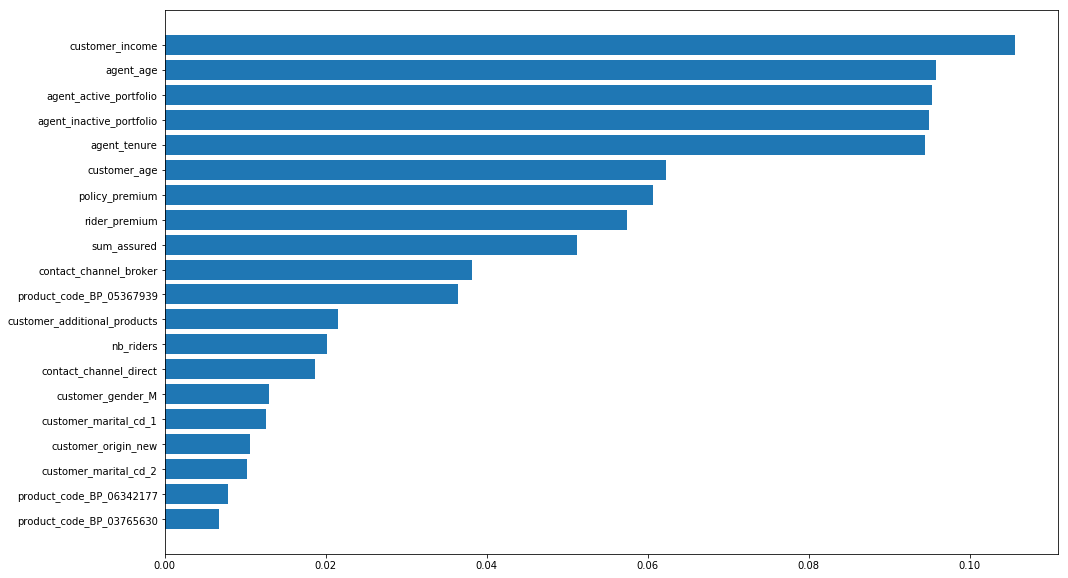

In [11]:
from matplotlib import pyplot as plt

feature_names = X.columns
feature_importance = clf.clf.feature_importances_

# Order by impact in the dataset
n = 20
order = feature_importance.argsort()
feature_names, feature_importance = feature_names[order], feature_importance[order]
feature_names, feature_importance = feature_names[-n:], feature_importance[-n:]

plt.figure(figsize=(16,10))
plt.barh(range(len(feature_names)), feature_importance, align="center")
plt.yticks(range(len(feature_names)), feature_names)
plt.show()

This chart is to be taken with a grain of salt. This shows the "order of importance" of the features in the iterative decisions made by the RandomForest classifier chosen here.

It is consistent with the product code study performed in the notebook `Datacamp_Final_Main` as the product codes appearing here are the ones we classified as "worst". In this context, it seems reasonable to consider the customer income and age, as well as the agents' age and portfolios as key factors leading to customer churn.

As a reminder, in `Datacamp_Final_Main`, the correlation plot showed that there is no correlation between an agent age and its portfolio, thus these 2 features must both be taken into account, and considered as different potential causal factors.

### 6.2 Visualizing the decision making process <a class="anchor" id="6.2-bullet"></a>

Some other models have other benefits, for exemple if we use a tree as a classifier, we can visualize the entire decision process.

cross_validated_score is 66.49 %


C:\Users\benja\Anaconda3\envs\benJ_1\lib\site-packages\sklearn\preprocessing\data.py:617: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\benja\Anaconda3\envs\benJ_1\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


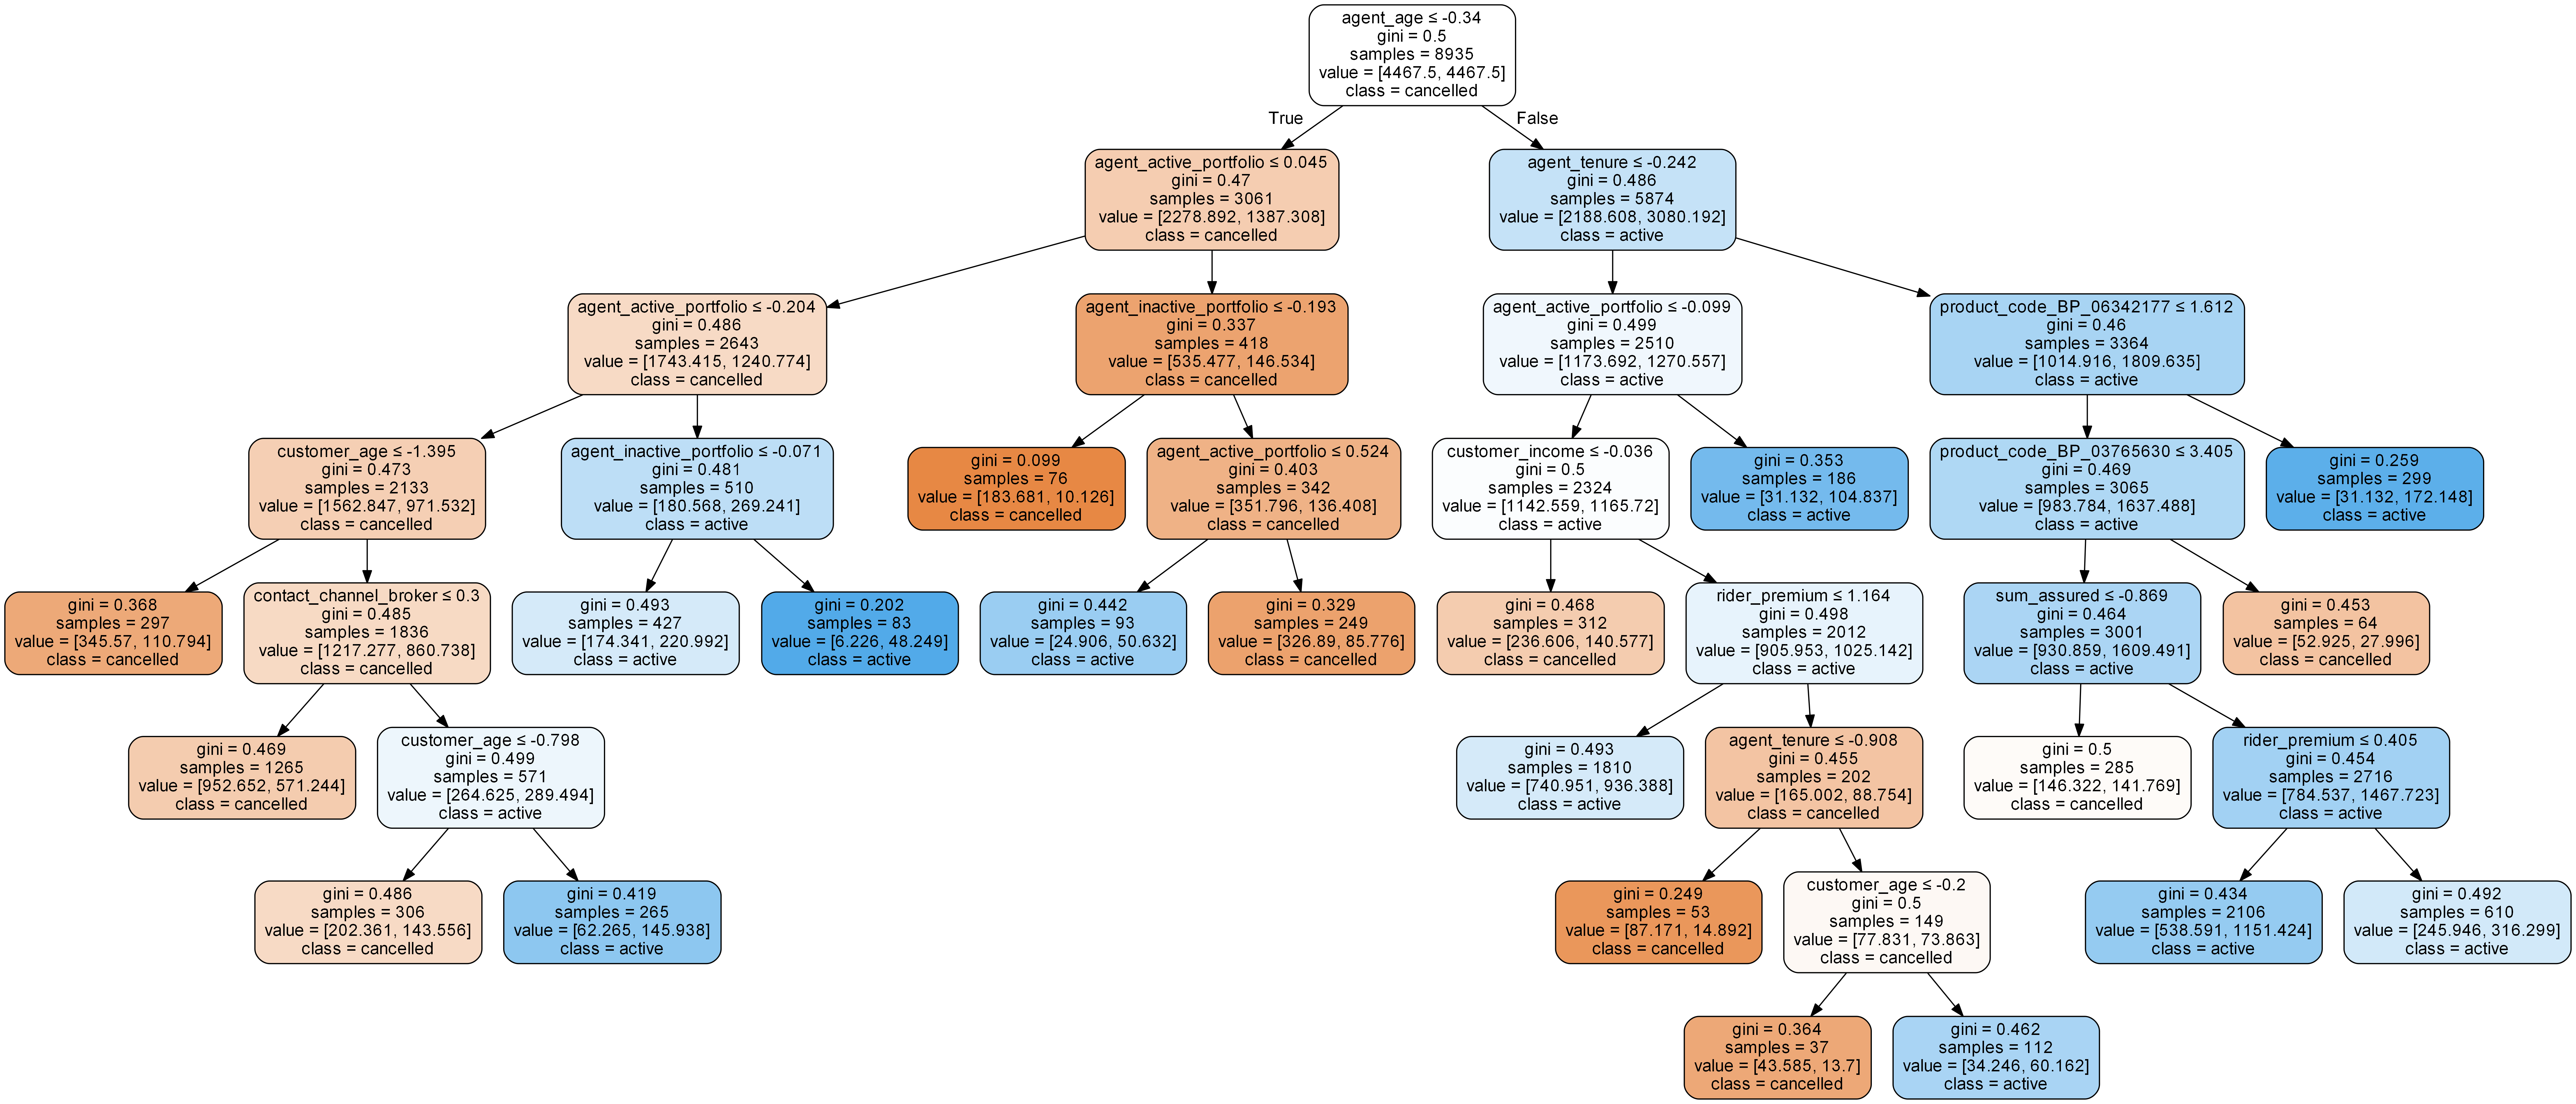

In [12]:
################################# Classifying with a tree on the top features only
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler

X_tree = X_train[feature_names.tolist()].copy()
scaler = StandardScaler()
X_tree_scaled = scaler.fit_transform(X_tree)
tree = DecisionTreeClassifier(class_weight="balanced", max_leaf_nodes=20)
tree.fit(X_tree_scaled, y_train)

cv_score_tree = np.array(cross_val_score(tree, X_tree_scaled, y=y_train, cv= 4, n_jobs=1, verbose=0)).mean()
print("cross_validated_score is %4.2f %%"%(cv_score_tree*100))

################################# Plotting the tree
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus

export_graphviz(tree, 
                out_file="tree.dot", 
                feature_names= feature_names.tolist(),
                class_names= ["cancelled", "active"],
                filled=True, 
                rounded=True,
                special_characters=True)
!dot -Tpng tree.dot -o tree.png -Gdpi=300  
Image(filename="graphviz/tree.png")

### 6.3 Conclusion <a class="anchor" id="6.3-bullet"></a>

With this starting kit, we are able to predict whether each contract hides a churner.

Relying on explainable models is essential here as this is what allows the insurer afterwards to improve its efficiency.
- Based on the most important features in the model, the insurer can understand what are the key drivers of business
- In the case of a tree, sub-cases (such as agent tenure for agents older than *some_threshold*) can be dealt with more easily.